In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

class Segment:
    def __init__(self, order, domain = (-1, 1)):
        self.n = (1 << order) + 1
        self.l = domain[1] - domain[0]
        self.x = 0.5*self.l*np.cos(np.pi*np.arange(self.n) / (self.n - 1)) + 0.5*(domain[1] + domain[0])
        self.w = np.zeros(self.n)
        self.w[::2] = 2 / (1 - np.arange(0, self.n, 2)**2)

    def fwd(self, f):
        f_ = scipy.fft.dct(f, type=1)
        f_[ 0] *= 0.5
        f_[-1] *= 0.5
        f_ /= (self.n - 1)
        return f_
    
    def bwd(self, f_):
        f_[ 0] /= 0.5
        f = scipy.fft.dct(f_, type=1)
        f *= 0.5
        return f

    def sum(self, f_):
        return np.sum(self.w * f_)
    def cte_op(self, c): return c * scipy.sparse.eye_array(self.n)
    def conv_op(self, lam0, lamN):
        s = scipy.sparse.eye_array(self.n)
        for lam in range(lam0, lamN): s = self._S_matrix(lam).dot(s)
        return s
    def der_op(self, lam, k):
        # C_{0} -> C_{k} -> C_{lam}
        c_k = (2 / self.l)**k * scipy.sparse.diags(2**(k - 1)*scipy.special.factorial(k - 1) * np.arange(k, self.n), offsets=k)
        return self.conv_op(k, lam).dot(c_k)
    def mul_op(self, lam, f_, eps=1e-15):
        if (lam == 0):
            f_[0] *= 2
            return 0.5 * (
                scipy.linalg.toeplitz(f_) + 
                np.pad(scipy.linalg.hankel(f_[1:]), ((1, 0), (0, 1)))
            )
        else:
            f_ = np.dot(self.conv_op(0, lam - 1), f_)
            m = self.n * 2

            ln = np.insert(np.arange(2 * lam, 2 * lam + m - 2) / (2 * np.arange(lam + 1, lam + m - 1)), 0, 0.5)
            lm = np.arange(1, m) / (2 * np.arange(lam, lam + m - 1))

            Mz = np.diag(lm, -1) + np.diag(ln, 1)
            M0 = np.eye(m)
            M1 = 2 * lam * Mz
            Mr = f_[0] * M0 + f_[1] * M1
            for k in range(1, self.n - 2):
                M2 = 2 * (k + lam) / (k + 1) * np.dot(Mz, M1) - (k + 2 * lam - 1) / (k + 1) * M0
                Mr += f_[k + 1] * M2
                M0 = M1
                M1 = M2
                if np.max(np.abs(f_[k + 2:])) < eps:
                    break
            return Mr[
                :self.n, 
                :self.n
            ]
    def _S_matrix(self, lam):
        if (lam == 0):
            return scipy.sparse.diags([np.concatenate((np.array([1.0]), 0.5 * np.ones(self.n - 1))), -0.5 * np.ones(self.n - 2)],
                                      offsets=[0, 2])
        else:
            return scipy.sparse.diags([
                 lam / (lam + np.arange(0, self.n)),
                -lam / (lam + np.arange(2, self.n))],
                                      offsets=[0, 2]
                                     )

In [2]:
import time
import tqdm
from functools import partial

import jax
import jax.numpy as jnp
from jax.experimental import sparse

jax.config.update(
  'jax_enable_x64', True
)

def _repeats_benchmark(func, repeats):
    def wrapper(n, *args, **kwargs):
        execution_time = []
        for _ in range(repeats):
            start_time = time.time()
            result = func(n, *args, **kwargs)
            end_time = time.time()
            execution_time.append(end_time - start_time)
        return (
            np.mean(execution_time), 
            np.var(execution_time)
        )
    return wrapper
benchmark = partial(_repeats_benchmark, repeats=10)

# Problem 1: Second order linear PDE

$$
\alpha \frac{\partial u^{2}}{\partial^{2} x} = f
$$
with Dirichlet boundary conditions solved with a Galerkin basis
$$
\begin{aligned}
u(-1) &= 3 \\
u(+1) &= 2
\end{aligned}
$$

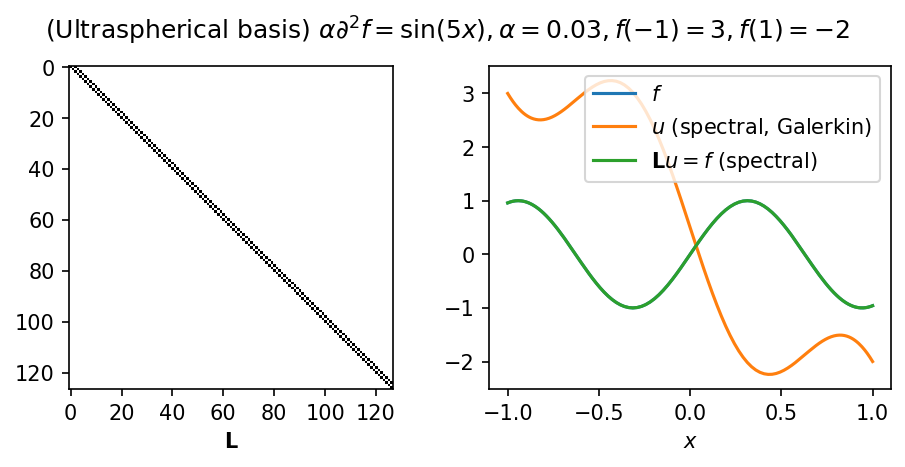

In [14]:
s_eq = Segment(order=7, domain=(-1, 1))

f  = np.sin(5*s_eq.x)
f_ = s_eq.fwd(f)
alpha = 0.03
L = alpha * s_eq.der_op(2, 2)# + s_eq.der_op(2, 1) + s_eq.conv_op(0, 2)

def stencil_mat():
  # dirichlet
  #   0:  1, 
  #  -2: -1
  return 2, scipy.sparse.diags([np.full(s_eq.n, 1.0), np.full(s_eq.n - 2, -1.0)], offsets=[0, -2])
def bwd_galerkin(fg, stencil, n_bcs):
    f_ = np.zeros(len(fg) + n_bcs, np.float64)
    f_[:len(fg)] = fg
    return stencil.dot(f_)

lift = -2.5*s_eq.x + 0.5
# at x = -1: (-2.5)*(-1) + 0.5 =  3
# at x = +1: (-2.5)*1 + 0.5    = -2
lhs_gal = L.copy()
rhs_gal = s_eq.conv_op(0, 2).dot(f_) - L.dot(s_eq.fwd(lift))

n_bcs, stencil = stencil_mat()
def bcs_gal(lhs, rhs):
  lhs = lhs.dot(stencil)
  lhs = lhs[:-n_bcs, :-n_bcs]
  rhs = rhs[:-n_bcs]
  return lhs, rhs

# Boundary conditions
lhs_gal, rhs_gal = bcs_gal(lhs_gal, rhs_gal)
u_gal = s_eq.bwd(bwd_galerkin(np.linalg.solve(lhs_gal.toarray(), rhs_gal), stencil, n_bcs)) + lift
u_target = np.linalg.solve(lhs_gal.toarray(), rhs_gal)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), dpi=150, constrained_layout=True)
axs[0].spy(lhs_gal.todense())
axs[0].xaxis.tick_bottom()
axs[0].set_xlabel(r"$\mathbf{L}$")
axs[1].plot(s_eq.x, f, label=r"$f$")
axs[1].plot(s_eq.x, u_gal, label=r"$u$ (spectral, Galerkin)")
axs[1].plot(s_eq.x, s_eq.bwd(np.dot(np.linalg.inv(s_eq.conv_op(0, 2).toarray()), L.dot(s_eq.fwd(u_gal)))), label=r"$\mathbf{L}u = f$ (spectral)")
axs[1].set_xlabel(r"$x$")
axs[1].legend()
fig.suptitle(r"(Ultraspherical basis) $\alpha \partial^2 f = \sin(5x), \alpha = 0.03, f(-1) = 3, f(1) = -2$")
plt.show()

Text(0.5, 0.98, '(Ultraspherical basis) $\\Delta f = e^{-10 (x + 0.2)^2 - 20 (y - 0.1)^2}$')

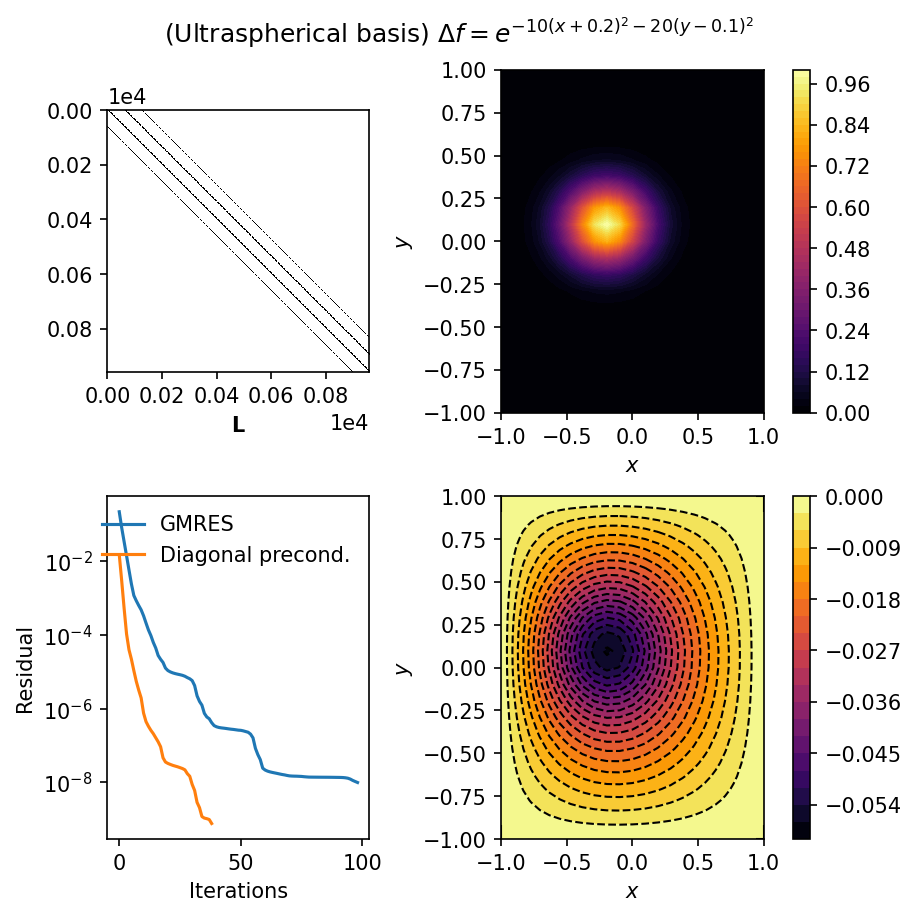

In [4]:
s_eq_x = Segment(order=5, domain=(-1, 1))
s_eq_y = Segment(order=5, domain=(-1, 1))
x, y = np.meshgrid(s_eq_x.x, s_eq_y.x)

Nx = s_eq_x.n
Ny = s_eq_y.n

#f = -100*x*np.sin(2*np.pi*x**2*y)*np.cos(4*np.pi*(x + y))
f = np.exp(-10*(x + 0.2)**2 - 20*(y - 0.1)**2)

f_x = scipy.fft.dct(f, type=1, axis=1)
f_x[:,  0] *= 0.5
f_x[:, -1] *= 0.5
f_x /= (s_eq_x.n - 1)
f_y = scipy.fft.dct(f_x, type=1, axis=0)
f_y[ 0, :] *= 0.5
f_y[-1, :] *= 0.5
f_y /= (s_eq_y.n - 1)
  
lhs_y = s_eq_y.der_op(2, 2)# - s_eq_y.cte_op(5).dot(s_eq_y.der_op(2, 1))
cid_y = s_eq_x.conv_op(0, 2)

cid_x = s_eq_y.conv_op(0, 2)
lhs_x = s_eq_x.der_op(2, 2)

def stencil_mat():
  # dirichlet
  #   0:  1, 
  #  -2: -1
  return 2, scipy.sparse.diags([np.full(s_eq_x.n, 1.0), np.full(s_eq_x.n - 2, -1.0)], offsets=[0, -2])

n_bcs, stencil = stencil_mat()
def bcs_gal(lhs):
  return lhs.dot(stencil)[:-n_bcs, :-n_bcs]

lhs_y = bcs_gal(lhs_y)
cid_y = bcs_gal(cid_y)
cid_x = bcs_gal(cid_x)
lhs_x = bcs_gal(lhs_x)

lhs_gal = scipy.sparse.kron(lhs_y, cid_y) + scipy.sparse.kron(cid_x, lhs_x)

f_y = s_eq_y.conv_op(0, 2).dot(f_y)
f_y = s_eq_x.conv_op(0, 2).dot(f_y.T).T
rhs = f_y[:-n_bcs, :-n_bcs]

res_krylov = []
(u_gal, flag) = scipy.sparse.linalg.gmres(lhs_gal, rhs.ravel(), rtol=1e-8, maxiter=250, callback=lambda x: res_krylov.append(x))
u_gal = u_gal.reshape(rhs.shape)

lhs_dia = scipy.sparse.diags(1.0 / lhs_gal.diagonal())
lhs_pre = scipy.sparse.linalg.LinearOperator(lhs_gal.shape, lambda u: lhs_dia.dot(u))

res_dia = []
(u_gal, flag) = scipy.sparse.linalg.gmres(lhs_gal, rhs.ravel(), M=lhs_pre, rtol=1e-8, maxiter=250, callback=lambda x: res_dia.append(x))
u_gal = u_gal.reshape(rhs.shape)

#L_ilu = scipy.sparse.linalg.spilu(scipy.sparse.csc_matrix(L_sp), fill_factor=1)
#L_pre = scipy.sparse.linalg.LinearOperator(L_sp.shape, lambda u: L_ilu.solve(u))

#res_ilu = []
#(u_gal, flag) = scipy.sparse.linalg.gmres(L_sp, rhs.ravel(), M=L_pre, rtol=1e-8, maxiter=250, callback=lambda x: res_ilu.append(x))
#u_gal = u_gal.reshape(rhs.shape)

sol_y = np.zeros((u_gal.shape[0] + n_bcs, u_gal.shape[1] + n_bcs), np.float64)
sol_y[:u_gal.shape[0], :u_gal.shape[1]] = u_gal
sol_y = stencil.dot(sol_y)
sol_y = stencil.dot(sol_y.T).T

sol_y[0, :] /= 0.5
sol_x = scipy.fft.dct(sol_y, type=1, axis=0)
sol_x *= 0.5
sol_x[:, 0] /= 0.5
sol = scipy.fft.dct(sol_x, type=1, axis=1)
sol *= 0.5

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), dpi=150, constrained_layout=True)
axs[0, 0].spy(lhs_gal.todense())
axs[0, 0].xaxis.tick_bottom()
axs[0, 0].ticklabel_format(axis='both', style='sci', scilimits=(4,4))
axs[0, 0].set_xlabel(r"$\mathbf{L}$")
axs[1, 0].semilogy(res_krylov, label=r"GMRES")
axs[1, 0].semilogy(res_dia, label=r"Diagonal precond.")
#axs[1].semilogy(res_ilu, label=r"ILU(0) GMRES")
axs[1, 0].set_xlabel(r"Iterations")
axs[1, 0].set_ylabel(r"Residual")
axs[1, 0].legend(frameon=False)
cs_r = axs[0, 1].contourf(s_eq_x.x, s_eq_y.x, f, levels=50, cmap='inferno')
axs[0, 1].set_xlabel(r"$x$")
axs[0, 1].set_ylabel(r"$y$")
cs_f = axs[1, 1].contourf(s_eq_x.x, s_eq_y.x, sol, levels=20, cmap='inferno')
axs[1, 1].contour(cs_f, colors='k', linewidths=1)
axs[1, 1].set_xlabel(r"$x$")
axs[1, 1].set_ylabel(r"$y$")

fig.colorbar(cs_r, ax=axs[0, 1])
fig.colorbar(cs_f, ax=axs[1, 1])
fig.suptitle(r"(Ultraspherical basis) $\Delta f = e^{-10 (x + 0.2)^2 - 20 (y - 0.1)^2}$")

# Performance benchmarks on the 1D Poisson problem with JAX

In [8]:
def benchmark_fun(order_max: int, dense: bool, fun):
    orders = np.arange(1, order_max)
    means = np.zeros_like(orders, dtype=np.float64)
    vars = np.zeros_like(orders, dtype=np.float64)

    def bench_dense(order):
        s_eq = Segment(order=order, domain=(-1, 1))

        f  = np.sin(5*s_eq.x)
        f_ = s_eq.fwd(f)
        L = 0.03 * s_eq.der_op(2, 2)# + s_eq.der_op(2, 1) + s_eq.conv_op(0, 2)

        def stencil_mat():
        # dirichlet
        #   0:  1, 
        #  -2: -1
            return 2, scipy.sparse.diags([np.full(s_eq.n, 1.0), np.full(s_eq.n - 2, -1.0)], offsets=[0, -2])
        def bwd_galerkin(fg, stencil, n_bcs):
            f_ = np.zeros(len(fg) + n_bcs, np.float64)
            f_[:len(fg)] = fg
            return stencil.dot(f_)

        lift = -2.5*s_eq.x + 0.5
        # at x = -1: (-2.5)*(-1) + 0.5 =  3
        # at x = +1: (-2.5)*1 + 0.5    = -2
        lhs_gal = L.copy()
        rhs_gal = s_eq.conv_op(0, 2).dot(f_) - L.dot(s_eq.fwd(lift))

        n_bcs, stencil = stencil_mat()
        def bcs_gal(lhs, rhs):
            lhs = lhs.dot(stencil)
            lhs = lhs[:-n_bcs, :-n_bcs]
            rhs = rhs[:-n_bcs]
            return lhs, rhs

        # Boundary conditions
        lhs_gal, rhs_gal = bcs_gal(lhs_gal, rhs_gal)

        if dense:
            lhs_jax = jax.numpy.array(lhs_gal.toarray())
        else:
            lhs_jax = sparse.BCOO.from_scipy_sparse(lhs_gal)
        rhs_jax = jax.numpy.array(rhs_gal)

        _ = fun(lhs_jax, rhs_jax.ravel())

        @benchmark
        def eval_dense(n):
            res = jax.block_until_ready(fun(lhs_jax, rhs_jax.ravel()))
        return eval_dense(s_eq.n)

    pbar = tqdm.tqdm(orders, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
    for i, order in enumerate(pbar):
        pbar.set_postfix(n=2**order + 1)
        mean, var = bench_dense(order)
        means[i] = mean
        vars[i] = var
    
    return orders, means, vars

In [9]:
inv_dense = jax.jit(jax.numpy.linalg.solve)
inv_gmres = jax.jit(partial(jax.scipy.sparse.linalg.gmres, tol=1e-8, maxiter=250))
inv_bicgstab = jax.jit(partial(jax.scipy.sparse.linalg.bicgstab, tol=1e-8, maxiter=250))

In [11]:
orders_dense, means_dense, vars_dense = benchmark_fun(15, True, inv_dense)
orders_gmres, means_gmres, vars_gmres = benchmark_fun(18, False, inv_gmres)
orders_bicgs, means_bicgs, vars_bicgs = benchmark_fun(18, False, inv_bicgstab)

100%|██████████| 17/17 [00:01<00:00, 11.59it/s, n=131073]                                                                                                                                                          


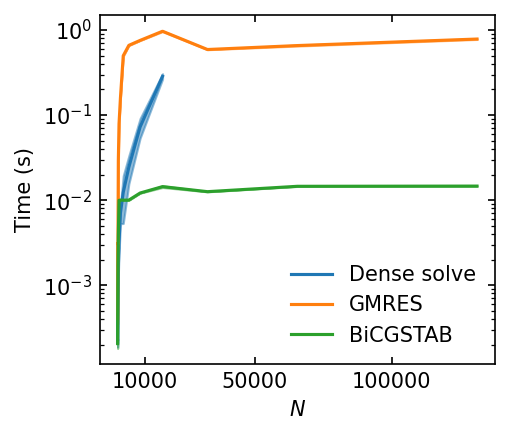

In [12]:
m_fig, m_axs = plt.subplots(ncols=1, nrows=1, figsize=(3.5, 3), dpi=150)

m_axs.semilogy(2**orders_dense - 1, means_dense, label=r'Dense solve', color='tab:blue')
m_axs.fill_between(2**orders_dense - 1, means_dense - np.sqrt(vars_dense), means_dense + np.sqrt(vars_dense), color='tab:blue', alpha=0.5)
m_axs.semilogy(2**orders_gmres - 1, means_gmres, label=r'GMRES', color='tab:orange')
m_axs.fill_between(2**orders_gmres - 1, means_gmres - np.sqrt(vars_gmres), means_gmres + np.sqrt(vars_gmres), color='tab:orange', alpha=0.5)
m_axs.semilogy(2**orders_bicgs - 1, means_bicgs, label=r'BiCGSTAB', color='tab:green')
m_axs.fill_between(2**orders_bicgs - 1, means_bicgs - np.sqrt(vars_bicgs), means_bicgs + np.sqrt(vars_bicgs), color='tab:green', alpha=0.5)

m_axs.set_xlabel(r'$N$')
m_axs.set_ylabel(r'Time (s)')
m_axs.set_xticks([10000, 50000, 100000])
m_axs.legend(frameon=False, loc='lower right')
m_axs.tick_params(reset=True, axis='both', which='both', direction='in')
m_fig.tight_layout()
plt.show()

### Learning $\alpha$ (static PDE)

We set-up the problem

$$
\operatorname{arg\,min}_{\alpha} \frac{1}{N} \sum_{i = 0}^{N} (\mathrm{solve}(\alpha L, \sin(5x))_{i} - u_{i})^{2}
$$

100%|██████████| 1000/1000 [00:05<00:00, 180.42it/s]                                                                                                                                                               


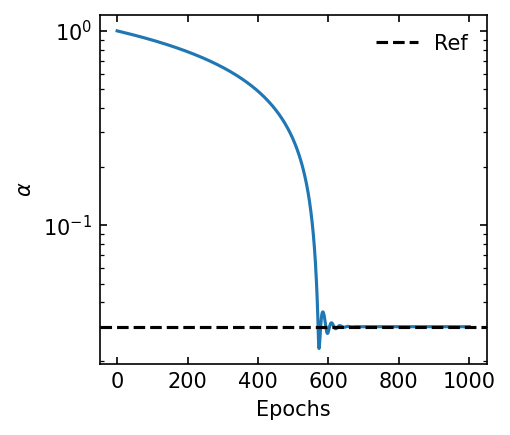

In [15]:
from flax import nnx
import optax

class DiffusionCoefficient(nnx.Module):
    def __init__(self):
        self.c = nnx.Param(jnp.ones((1,)))
    def __call__(self, x: jax.Array):
        return self.c * x

model = DiffusionCoefficient()
optimizer = nnx.Optimizer(model, optax.adam(1e-3))

@nnx.jit
def train_step(model, optimizer, lhs, y):
  def loss_fn(model):
    lhs_pred = model(lhs)
    (u_pred_gal, _) = jax.scipy.sparse.linalg.bicgstab(lhs_pred, rhs_jax, tol=1e-8, maxiter=1000)
    return ((u_pred_gal - y) ** 2).mean()
  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)
  return loss

lhs_prob = s_eq.der_op(2, 2).dot(stencil)
lhs_prob = lhs_prob[:-n_bcs, :-n_bcs]
lhs_prob = sparse.BCOO.from_scipy_sparse(lhs_prob)

stencil_jax = sparse.BCOO.from_scipy_sparse(stencil)
rhs_jax = jax.numpy.array(rhs_gal)

coef_c = [model.c[0]]
epochs = 1000
pbar = tqdm.tqdm(range(epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
for _ in pbar:
    train_step(model, optimizer, lhs_prob, u_target)
    coef_c.append(model.c[0])

m_fig, m_axs = plt.subplots(ncols=1, nrows=1, figsize=(3.5, 3), dpi=150)

m_axs.semilogy(coef_c)
m_axs.axhline(alpha, color='k', linestyle='--', label=r'Ref')

m_axs.set_xlabel(r'Epochs')
m_axs.set_ylabel(r'$\alpha$')
m_axs.legend(frameon=False)
m_axs.tick_params(reset=True, axis='both', which='both', direction='in')
#m_axs.ticklabel_format(useMathText=True)
m_fig.tight_layout()
plt.show()

/tmp/ipykernel_1635804/1188959959.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  m_axs[0].legend(frameon=False)


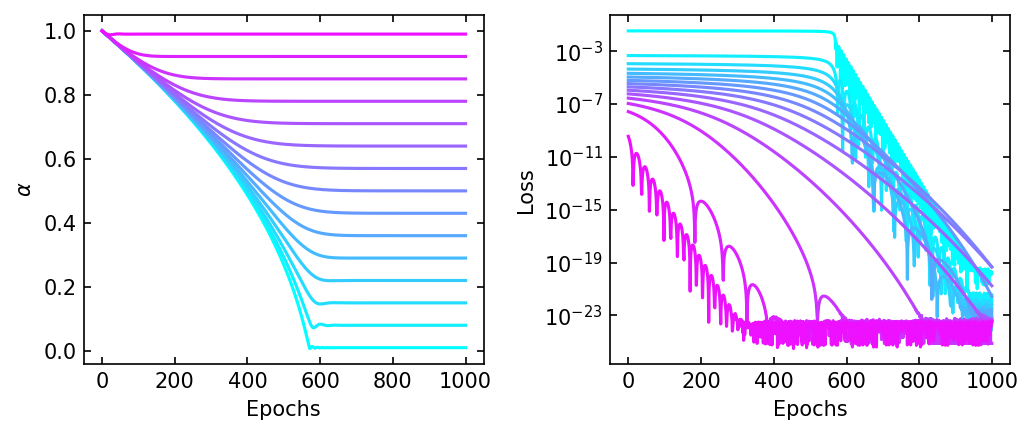

In [16]:
alpha_values = jnp.linspace(1e-2, 1-1e-2, 15)

losses = np.zeros((alpha_values.shape[0], epochs))
coefs = np.zeros((alpha_values.shape[0], epochs+1))

for i_alpha, alpha in enumerate(alpha_values):
    # target solution
    L = alpha * s_eq.der_op(2, 2)
    lhs_gal = L.copy()
    rhs_gal = s_eq.conv_op(0, 2).dot(f_) - L.dot(s_eq.fwd(lift))
    lhs_gal, rhs_gal = bcs_gal(lhs_gal, rhs_gal)
    u_gal = s_eq.bwd(bwd_galerkin(np.linalg.solve(lhs_gal.toarray(), rhs_gal), stencil, n_bcs)) + lift
    u_target = np.linalg.solve(lhs_gal.toarray(), rhs_gal)

    # calibration
    model = DiffusionCoefficient()
    optimizer = nnx.Optimizer(model, optax.adam(1e-3))
    coefs[i_alpha, 0] = model.c[0]
    for epoch in range(epochs):
        loss = train_step(model, optimizer, lhs_prob, u_target)
        losses[i_alpha, epoch] = loss
        coefs[i_alpha, epoch+1] = model.c[0]

m_fig, m_axs = plt.subplots(ncols=2, nrows=1, figsize=(7, 3), dpi=150)

import matplotlib.cm as cm
for i_alpha in range(alpha_values.shape[0]):
    m_axs[0].plot(coefs[i_alpha, :], color=cm.cool(i_alpha/alpha_values.shape[0]))
for i_alpha in range(alpha_values.shape[0]):
    m_axs[1].semilogy(losses[i_alpha, :], color=cm.cool(i_alpha/alpha_values.shape[0]))

m_axs[0].set_xlabel(r'Epochs')
m_axs[0].set_ylabel(r'$\alpha$')
m_axs[0].legend(frameon=False)
m_axs[0].tick_params(reset=True, axis='both', which='both', direction='in')

m_axs[1].semilogy(loss)
m_axs[1].set_xlabel(r'Epochs')
m_axs[1].set_ylabel(r'Loss')
m_axs[1].tick_params(reset=True, axis='both', which='both', direction='in')

m_fig.tight_layout()
plt.show()

# Problem 2: Second order linear PDE (dynamical)

$$
\frac{\partial u}{\partial t} + \alpha \frac{\partial u^{2}}{\partial^{2} x} = 0
$$
with initial conditions
$$
u(t = 0) = e^{-(5 x)^2}
$$
with Dirichlet boundary conditions solved with a Galerkin basis
$$
\begin{aligned}
u(-1) &= 0 \\
u(+1) &= 0
\end{aligned}
$$

In [5]:
import jax.numpy as jnp

_imex2_ɣ = 0.5 * (2.0 - jnp.sqrt(2))
_imex2_δ = 1.0 - 0.5 / _imex2_ɣ

def imex2(y, exp, imp, sol, dt):
    # y = 1
    y_g0 = exp(y)
    # s = 1; A_ex[1,0] = ɣ
    y_si = y + dt * _imex2_ɣ * y_g0
    y_si = sol(y_si)
    # y = 2
    y_A1 = imp(y_si)
    y_g1 = exp(y_si)
    # s = 2; 
    # A_ex[2,0] = δ
    # A_ex[2,1] = 1 - δ, A_im[2,1] = 1 - ɣ
    y_si = y + dt * (_imex2_δ * y_g0 + (1 - _imex2_δ) * y_g1) + dt * (1 - _imex2_ɣ) * y_A1
    return sol(
      y_si
    )

def bwd_galerkin_jax(fg, stencil, n_bcs):
    f_ = jnp.zeros(len(fg) + n_bcs, jnp.float64)
    f_ = f_.at[:len(fg)].set(fg)
    return stencil @ f_

alpha_dyn = 1e-2
imp = alpha_dyn * s_eq.der_op(2, 2)
us_I = s_eq.conv_op(0, 2)

dt = 0.5
lhs_dyn = us_I - dt * _imex2_ɣ * imp
lhs_dyn = lhs_dyn.dot(stencil)
lhs_dyn = lhs_dyn[:-n_bcs, :-n_bcs]

imp_jax = sparse.BCOO.from_scipy_sparse(imp)
lhs_jax = sparse.BCOO.from_scipy_sparse(lhs_dyn)
stencil_jax = sparse.BCOO.from_scipy_sparse(stencil)

def explicit(y):
    return 0
def implicit(y):
    imp_us = imp_jax @ y
    return imp_us

bicgstab_jit = jax.jit(jax.scipy.sparse.linalg.bicgstab)
def sol(y):
    (res_gal, _) = bicgstab_jit(lhs_jax, y[:-n_bcs], tol=1e-8, maxiter=250)
    res = bwd_galerkin_jax(res_gal, stencil_jax, n_bcs)
    return res

100%|██████████| 5/5 [00:00<00:00,  6.22it/s]                                                                                                                                                                      


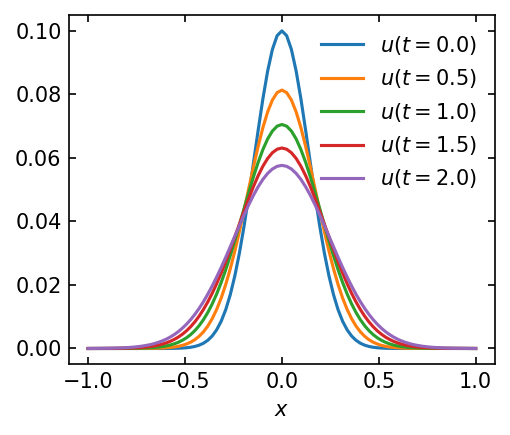

In [6]:
m_fig, m_axs = plt.subplots(ncols=1, nrows=1, figsize=(3.5, 3), dpi=150)

f = 0.1 * np.exp(-(5 * s_eq.x)**2)
f_ = s_eq.fwd(f)

t = 0.0
iters = 5
pbar = tqdm.tqdm(range(iters), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
for i in pbar:
    if i % 1 == 0:
        m_axs.plot(s_eq.x, s_eq.bwd(np.array(f_)), label=r'$u(t = ' + str(t) + ')$')
    f_ = us_I.dot(f_)
    f_ = imex2(f_, explicit, implicit, sol, dt)
    t += dt

u_final = f_.copy()

m_axs.set_xlabel(r'$x$')
m_axs.legend(frameon=False)
m_axs.tick_params(reset=True, axis='both', which='both', direction='in')
#m_axs.ticklabel_format(useMathText=True)
m_fig.tight_layout()
plt.show()

### Learning $\alpha$ (dynamical PDE)

We set-up the problem

$$
\operatorname{arg\,min}_{\alpha} \frac{1}{N} \sum_{i = 0}^{N} \left( \int_{t_{0}}^{t} \left[ Lu(t') \, \mathrm{d} t' \right]_{i} - u(t)_{i} \right)^{2}
$$

100%|██████████| 500/500 [00:19<00:00, 25.12it/s]                                                                                                                                                                  


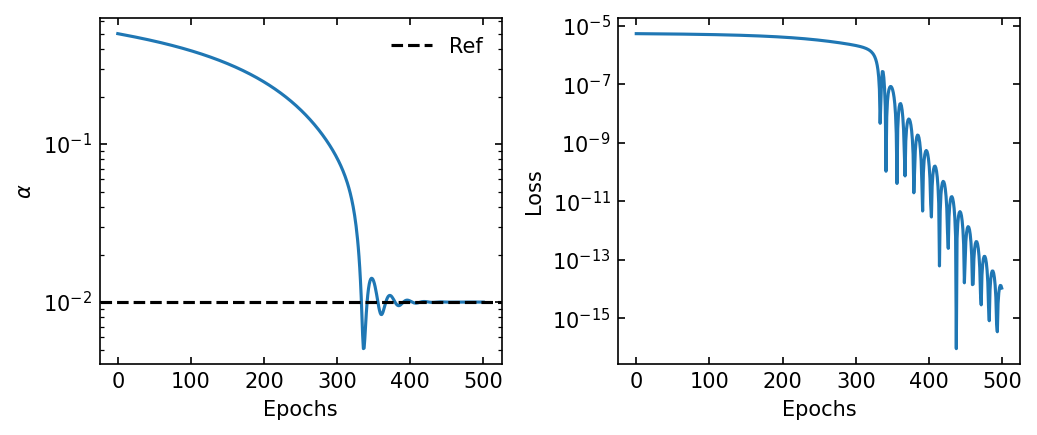

In [8]:
class DiffusionCoefficient(nnx.Module):
    def __init__(self):
        self.c = nnx.Param(jnp.array([0.5], dtype=jnp.float64))
    def __call__(self, x: jax.Array):
        return self.c * x

model = DiffusionCoefficient()
optimizer = nnx.Optimizer(model, optax.adam(1e-3))

@nnx.jit
def train_step(model, optimizer, lhs_imp, lhs_gal, y):
  def loss_fn(model):
    lhs_imp_ = model(lhs_imp)
    lhs_gal_ = model(lhs_gal)
    lhs_gal_ = us_I_gal - dt * _imex2_ɣ * lhs_gal_
    
    def explicit(y):
        return 0
    def implicit(y):
        imp_us = lhs_imp_ @ y
        return imp_us
    def sol(y):
        (res_gal, _) = bicgstab_jit(lhs_gal_, y[:-n_bcs], tol=1e-8, maxiter=250)
        res = bwd_galerkin_jax(res_gal, stencil_jax, n_bcs)
        return res
      
    f_rhs = f_jax.copy()
    for i in range(iters):
        f_rhs = us_I_jax @ f_rhs
        f_rhs = imex2(f_rhs, explicit, implicit, sol, dt)
    return ((f_rhs - y) ** 2).mean()
  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)
  return loss

f = 0.1 * np.exp(-(5 * s_eq.x)**2)
f_ = s_eq.fwd(f)
f_jax = jnp.array(f_)

us_I = s_eq.conv_op(0, 2)
us_I_gal = us_I.dot(stencil)
us_I_gal = us_I_gal[:-n_bcs, :-n_bcs]

us_I_gal = sparse.BCOO.from_scipy_sparse(us_I_gal)
us_I_jax = sparse.BCOO.from_scipy_sparse(us_I)

lhs_imp = s_eq.der_op(2, 2)
lhs_gal = lhs_imp.dot(stencil)
lhs_gal = lhs_gal[:-n_bcs, :-n_bcs]

lhs_imp = sparse.BCOO.from_scipy_sparse(lhs_imp)
lhs_gal = sparse.BCOO.from_scipy_sparse(lhs_gal)

stencil_jax = sparse.BCOO.from_scipy_sparse(stencil)

loss = []
coef_c = [model.c[0]]
epochs = 500
pbar = tqdm.tqdm(range(epochs), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}')
for _ in pbar:
    loss.append(train_step(model, optimizer, lhs_imp, lhs_gal, u_final))
    coef_c.append(model.c[0])
    
m_fig, m_axs = plt.subplots(ncols=2, nrows=1, figsize=(7, 3), dpi=150)

m_axs[0].semilogy(coef_c)
m_axs[0].axhline(alpha_dyn, color='k', linestyle='--', label=r'Ref')

m_axs[0].set_xlabel(r'Epochs')
m_axs[0].set_ylabel(r'$\alpha$')
m_axs[0].legend(frameon=False)
m_axs[0].tick_params(reset=True, axis='both', which='both', direction='in')

m_axs[1].semilogy(loss)
m_axs[1].set_xlabel(r'Epochs')
m_axs[1].set_ylabel(r'Loss')
m_axs[1].tick_params(reset=True, axis='both', which='both', direction='in')

m_fig.tight_layout()
plt.show()